## Ознакомление с задачей проекта
**Телеком — задача проекта**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
    - customerID
    - BeginDate – дата начала пользования услугами,
    - EndDate – дата окончания пользования услугами,
    - Type – тип договора: ежемесячный, годовой и т.д,
    - PaperlessBilling – факт выставления счёта на электронную почту,
    - PaymentMethod – способ оплаты,
    - MonthlyCharges – ежемесячные траты на услуги,
    - TotalCharges – всего потрачено денег на услуги,
    
    
- `personal.csv` — персональные данные клиента;
    - customerID
    - Dependents – наличие иждивенцев,
    - Senior Citizen – наличие пенсионного статуса по возрасту,
    - Partner – наличие супруга(и),
   
   
- `internet.csv` — информация об интернет-услугах;
    - customerID
    - InternetService
    - OnlineSecurity
    - OnlineBackup
    - DeviceProtection
    - TechSupport
    - StreamingTV
    - StreamingMovies
    
    
- `phone.csv` — информация об услугах телефонии
    - customerID
    - MultipleLines – наличие возможности ведения параллельных линий во время звонка.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.


## Ознакомление с исходными данными

In [207]:
import sys

!"{sys.executable}" -m pip install phik

In [208]:
import pandas as pd 
import numpy as np
import datetime
from functools import reduce
import matplotlib as mpl
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier


from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

import time

import warnings
warnings.filterwarnings('ignore')

Загрузим исходные данные, для удобства отображения присвоим переменным имена:

In [209]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_contract.name = '"Информация о договоре"'
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_personal.name = '"Персональные данные клиента"'
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_internet.name = '"Информация об интернет-услугах"'
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
df_phone.name = '"Информация об услугах телефонии"'

Реализуем отображение общих данных об исходных датафреймах через цикл:

In [210]:
for df in (df_contract, df_personal, df_internet, df_phone):
    print('Общий вид датафрейма', df.name)
    display(df.sample(5))
    print('Количество признаков', df.shape[1], '\n')
    print('Список признаков', '\n', df.columns.tolist(), '\n')    
    print('Общая информация о датафрейме', df.name, '\n')
    df.info()
    print('\n', 'Статистические сведения о датафрейме', df.name)
    display(df.describe())

Общий вид датафрейма "Информация о договоре"


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6694,4526-RMTLL,2019-06-01,No,Two year,Yes,Credit card (automatic),76.15,645.8
4197,5934-RMPOV,2018-04-01,No,Month-to-month,Yes,Electronic check,84.75,1816.75
5214,2983-ZANRP,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),73.55,145.4
3796,8614-VGMMV,2018-10-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,49.10,679.55
661,8095-WANWK,2019-04-01,No,Month-to-month,No,Mailed check,45.25,428.7


Количество признаков 8 

Список признаков 
 ['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges'] 

Общая информация о датафрейме "Информация о договоре" 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

 Статистические сведения о датафрейме "Информация о договоре"


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Общий вид датафрейма "Персональные данные клиента"


,customerID,gender,SeniorCitizen,Partner,Dependents
6971,7240-FQLHE,Female,1,Yes,No
3713,6961-VCPMC,Male,1,Yes,No
872,1764-VUUMT,Male,0,No,Yes
849,7408-OFWXJ,Female,0,Yes,Yes
1488,8695-WDYEA,Male,0,No,No


Количество признаков 5 

Список признаков 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'] 

Общая информация о датафрейме "Персональные данные клиента" 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

 Статистические сведения о датафрейме "Персональные данные клиента"


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Общий вид датафрейма "Информация об интернет-услугах"


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3697,3050-RLLXC,DSL,Yes,Yes,Yes,Yes,Yes,No
2415,5052-PNLOS,Fiber optic,No,Yes,Yes,No,Yes,Yes
1897,1089-HDMKP,DSL,No,Yes,No,Yes,No,No
3504,7465-ZZRVX,Fiber optic,No,No,No,No,No,No
1034,5027-XWQHA,DSL,No,No,No,No,No,No


Количество признаков 8 

Список признаков 
 ['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'] 

Общая информация о датафрейме "Информация об интернет-услугах" 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

 Статистические сведения о датафрейме "Информация об интернет-услугах"


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0928-XUTSN,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Общий вид датафрейма "Информация об услугах телефонии"


,customerID,MultipleLines
1622,5605-XNWEN,Yes
5546,9924-JPRMC,Yes
2129,3097-PYWXL,No
4792,3049-SOLAY,Yes
4751,7841-FCRQD,No


Количество признаков 2 

Список признаков 
 ['customerID', 'MultipleLines'] 

Общая информация о датафрейме "Информация об услугах телефонии" 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

 Статистические сведения о датафрейме "Информация об услугах телефонии"


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5016-IBERQ,No
freq,1,3390


**Вывод:**
- Количество строк в df_contract и df_personal одинаковое, тогда как в df_internet и df_phone строк меньше, т.е. не все клиенты пользуются и стационарной телефонной связью, и интернетом.
- Большинство столбцов имеют строковый тип данных, поэтому метод describe() не дал нам никакой полезной информации
- Судя по первичному обзору данных аномальных значений в данных нет

## Обработка исходных данных

Для датафрейма **df_contract** выполним следующие действия:
- создадим новый столбец **CustomerOutflow**, где 1 - клиент ушел, 0 - клиент остался
- приведем столбцы **BeginDate** и **EndDate** к типу datetime, в **EndDate** значение "No", заменим на "2020-02-01"
- создадим столбец **LoyaltyPeriod**, где посчитаем срок лояльности клиента в месяцах, поскольку все данные в столбцах **BeginDate** и **EndDate** указаны от 1 числа каждого месяца
- удалим за ненадобностью столбцы **BeginDate** и **EndDate**
- значения столбца **TotalCharges** приведем к типу данных float

In [211]:
# создаем столбец "CustomerOutflow" согласно вышеописанному условию
df_contract.insert(1, "CustomerOutflow", [0 if x == 'No' else 1 for x in df_contract['EndDate']])

# заменим значение NO на 2020-02-01 в столбце EndDate
df_contract['EndDate'] = df_contract['EndDate'].replace('No','2020-02-01')

# изменим типы данных столбцов BeginDate и EndDate
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'])

# создаем столбец "LoyaltyPeriod", куда внесем данные о сроке лоялности клиента в месяцах
df_contract.insert(2, "LoyaltyPeriod", 
                   np.round((df_contract['EndDate'] - df_contract['BeginDate'])/np.timedelta64(1, 'M')).astype('int'))

# изменим тип данных столбца TotalCharges на числовой
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

In [212]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   CustomerOutflow   7043 non-null   int64         
 2   LoyaltyPeriod     7043 non-null   int64         
 3   BeginDate         7043 non-null   datetime64[ns]
 4   EndDate           7043 non-null   datetime64[ns]
 5   Type              7043 non-null   object        
 6   PaperlessBilling  7043 non-null   object        
 7   PaymentMethod     7043 non-null   object        
 8   MonthlyCharges    7043 non-null   float64       
 9   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


При изменении типа данных в столбце **TotalCharges** появились пропущенные значения из-за указанного параметра errors='coerce'.
Посмотрим на строки, где появились NaNы:

In [213]:
print("Количество пропущенных значений:", df_contract['TotalCharges'].isnull().sum(), '\n')
print("Строки датафрейма с пропущенными значениями")
display(df_contract[df_contract.isnull().any(axis=1)])

Количество пропущенных значений: 11 

Строки датафрейма с пропущенными значениями


,customerID,CustomerOutflow,LoyaltyPeriod,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,0,0,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,0,0,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,0,0,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,0,0,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,0,0,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,0,0,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,0,0,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,0,0,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,0,0,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,0,0,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


Все строки, где появились пропущенные значения в столбце **TotalCharges**, это данные о контрактах, которые были заключены на дату формирования датафрейма, т.е. 1 февраля 2020 года. На данном этапе заменим появившиеся NaNы на соответствующие значения из столбца **MonthlyCharges**:

In [214]:
df_contract['TotalCharges'] = np.where(df_contract['TotalCharges'].isna() , df_contract['MonthlyCharges'], df_contract['TotalCharges'])

Удалим столбцы **BeginDate** и **EndDate**

In [215]:
df_contract = df_contract.drop(['BeginDate', 'EndDate'], axis=1)

In [216]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   CustomerOutflow   7043 non-null   int64  
 2   LoyaltyPeriod     7043 non-null   int64  
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


Оставшиеся датафреймы оставим без изменений и приступим к объединению в один датафрейм.

In [217]:
df = reduce(lambda left,right: pd.merge(left, right, on='customerID', how='left'), [df_contract, df_personal, df_internet, df_phone])

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   CustomerOutflow   7043 non-null   int64  
 2   LoyaltyPeriod     7043 non-null   int64  
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


После объединения таблиц появились пропуски из-за меньшего размера фреймов df_internet и df_phone. Проверим, есть ли совпадения среди пропущенных значений из этих табиц:

In [219]:
len(list(set(df[df.MultipleLines.isna()].index).intersection(df[df.InternetService.isna()].index)))

0

Совпадений нет, посмотрим на значения столбца **MultipleLines** для строк, где в столбце **InternetService** значения пропущены:

In [220]:
df[df.InternetService.isna()]['MultipleLines'].value_counts()

No     1184
Yes     342
Name: MultipleLines, dtype: int64

Большинство из клиентов, которые не пользуются интернет-услугами, также не имеют возможности ведения параллельных линий во время звонка. Теперь посмотрим на значения столбца **InternetService** для строк, где в столбце **MultipleLines** значения пропущены:

In [221]:
df[df.MultipleLines.isna()]['InternetService'].value_counts()

DSL    682
Name: InternetService, dtype: int64

Все клиенты, которых не было в исходном датасете df_phone используют интернет-соединение DSL. Взглянем на значения столбца **MultipleLines** для пользователей, имеющих DSL соединение:

In [222]:
df[df['InternetService'] == 'DSL']['MultipleLines'].value_counts()

No     1048
Yes     691
Name: MultipleLines, dtype: int64

У большинства пользователей с DSL соединением отсутствует возможность ведения параллельных линий во время звонка. Исходя из вышеописанных действий однозначного решения - как качественнее заполнить пропущенные значения, определить нельзя. Но наиболее подходящим, считаю, заполнить все пропуски значением **"No"**, критично повлиять на качество модели такое заполнение не должно.

In [223]:
df = df.fillna('No')
df.isna().sum()

customerID          0
CustomerOutflow     0
LoyaltyPeriod       0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Пропусков больше не осталось, проверим на наличие дубликатов:

In [224]:
df.duplicated().sum()

0

Дубликатов тоже нет, можно перейти к исследовательскому анализу данных.

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   CustomerOutflow   7043 non-null   int64  
 2   LoyaltyPeriod     7043 non-null   int64  
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


## Исследовательский анализ данных

Изучим корреляцию признаков между собой при помощи библиотеки Phik, которая позволит изучить наличие мультиколлинеарности всех признаков независимо от их типа.

Вручную укажем переменные, которые мы относим к непрерывным, это **'LoyaltyPeriod', 'MonthlyCharges' и 'TotalCharges'**. Для наглядности отображения построим тепловую карту корреляции признаков.

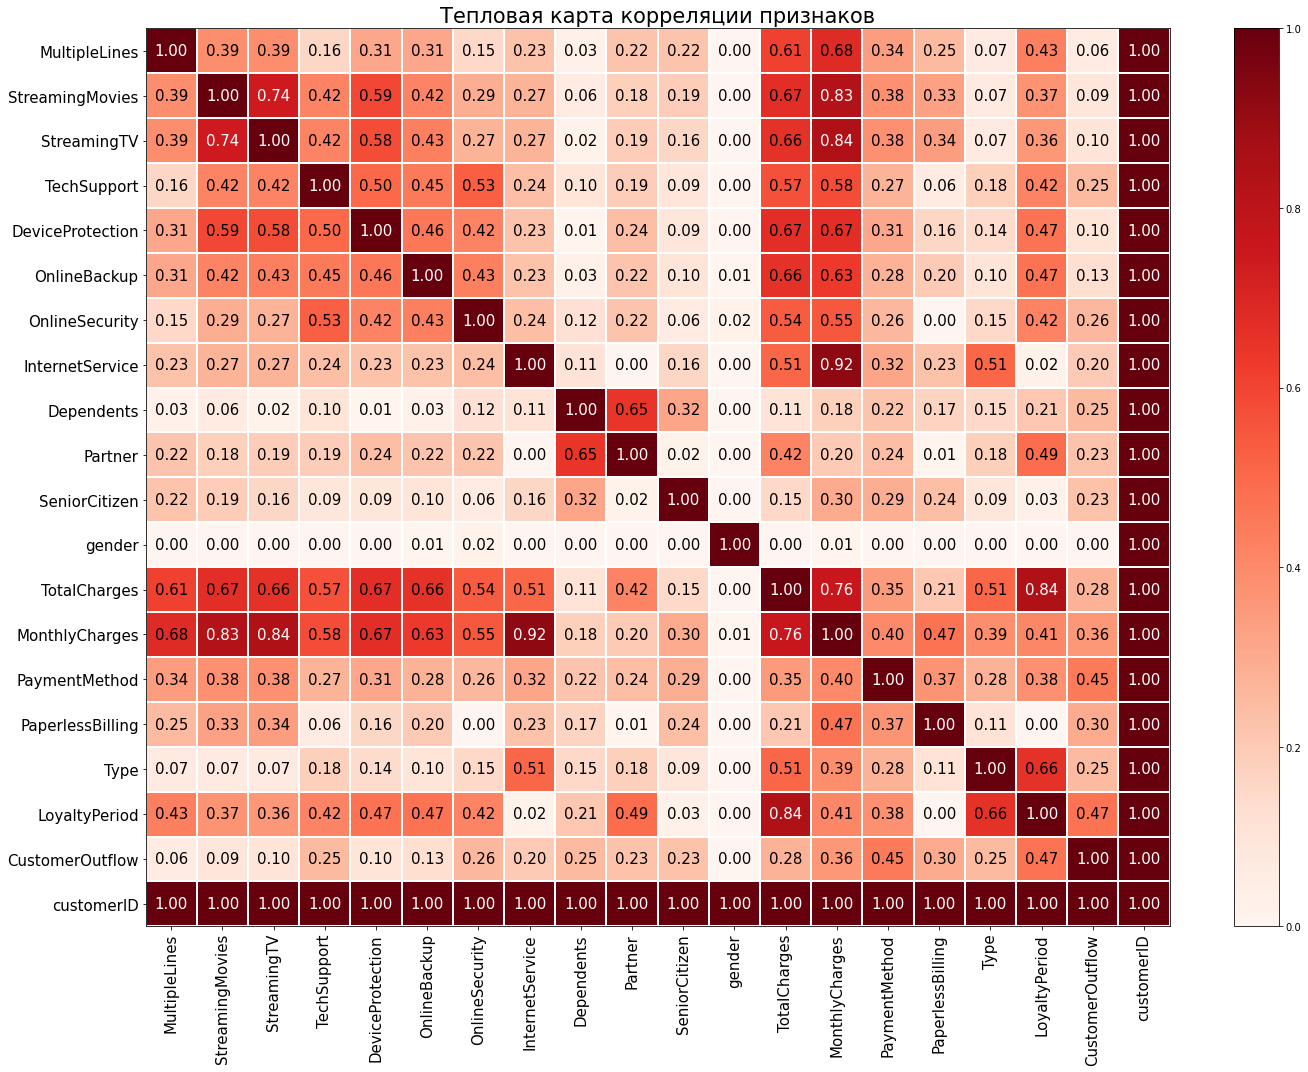

In [226]:
interval_cols = ['LoyaltyPeriod', 'MonthlyCharges', 'TotalCharges']
phik_overview = df.phik_matrix(interval_cols=interval_cols).round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Reds", 
                        title=r"Тепловая карта корреляции признаков", 
                        fontsize_factor=1.5, 
                        figsize=(20, 15))
plt.tight_layout()

Исходя из полученной карты корреляции можно сказать:

- **customerID** ненужный признак, который следует удалить
- признаки **MonthlyCharges** и **TotalCharges** сильно коррелируют с большинством других признаков, что логично - ежемесячные траты и сумма трат за весь период прямо пропорционально зависят от подключенных услуг
- признак лояльности клиента **LoyaltyPeriod** также коррелирует с другими признаками, особенно с **TotalCharges** (что логично), а также высокая корреляция с признаком **Type** (что тоже можно объяснить - чем на больший период заключен договор, тем выше окажется рассчитанный нами период лояльности)
- целевой признак **CustomerOutflow** наибольшую корреляцию показывает с признаками **PaymentMethod** (наличие большого выбора способов оплаты снижает риск ухода клиента) и **LoyaltyPeriod** (чем выше период лояльности, тем меньше риск ухода клиента)

На данном этапе удалим лишь столбец **customerID** за ненадобностью. Оставшиеся столбцы пока оставим без изменений, в ходе обучения модели можно с этими столбцами поэкспериментировать, добиваясь лучшего качества модели.

In [227]:
df = df.drop(['customerID'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerOutflow   7043 non-null   int64  
 1   LoyaltyPeriod     7043 non-null   int64  
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null   object 


Исследуем целевой признак **CustomerOutflow** на баланс данных:

0    5174
1    1869
Name: CustomerOutflow, dtype: int64

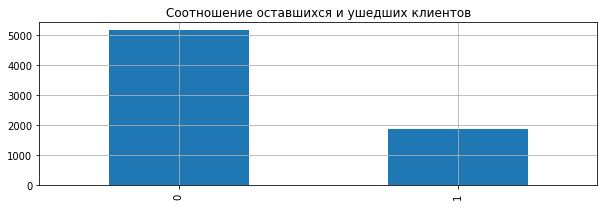

In [228]:
df['CustomerOutflow'].value_counts().plot(kind='bar', grid=True, figsize=(10, 3),title='Соотношение оставшихся и ушедших клиентов')
df['CustomerOutflow'].value_counts()

В данных явный дисбаланс, соотношение ушедших клиентов к оставшимся примерно 1:3. Это нужно учесть на кросс-валидации при подборе оптимальных параметров модели.

## Подготовка данных к обучению модели

### Кодирование категориальных признаков

Посмотрим на уникальные значения категориальных признаков для выбора метода кодирования:

In [229]:
cat_features = df.columns.tolist() # решил, что таким способом я быстрее составлю список категориальных признаков)))
del cat_features[0:2]
del cat_features[3:5]
del cat_features[4:5]

for feature in cat_features:
    print("Уникальные значения столбца", feature, "-", df[feature].unique())

Уникальные значения столбца Type - ['Month-to-month' 'One year' 'Two year']
Уникальные значения столбца PaperlessBilling - ['Yes' 'No']
Уникальные значения столбца PaymentMethod - ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Уникальные значения столбца gender - ['Female' 'Male']
Уникальные значения столбца Partner - ['Yes' 'No']
Уникальные значения столбца Dependents - ['No' 'Yes']
Уникальные значения столбца InternetService - ['DSL' 'Fiber optic' 'No']
Уникальные значения столбца OnlineSecurity - ['No' 'Yes']
Уникальные значения столбца OnlineBackup - ['Yes' 'No']
Уникальные значения столбца DeviceProtection - ['No' 'Yes']
Уникальные значения столбца TechSupport - ['No' 'Yes']
Уникальные значения столбца StreamingTV - ['No' 'Yes']
Уникальные значения столбца StreamingMovies - ['No' 'Yes']
Уникальные значения столбца MultipleLines - ['No' 'Yes']


Для кодирования признаков используем метод *OneHotEncoder*:

In [232]:
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

### Деление выборки для обучения моделей

Разделим выборку на обучающую и тестовую в отношении 80:20, определим признаки и целевой признак:

In [235]:
# Разделение датасет на train, test
X = df.drop(['CustomerOutflow'], axis=1)
y = df['CustomerOutflow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=80822)

print(X_train.shape, X_test.shape)

(5634, 22) (1409, 22)


Масштабируем численные признаки, обучив scaler на трейне:

In [236]:
num_features = ['LoyaltyPeriod', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']

scaler = StandardScaler()
scaler.fit(X_train[num_features]) 

X_train[num_features]= scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features]) 

## Обучение моделей

Создадим собственную функцию для подбора оптимальных гиперпараметров обучаемых моделей, для оценки качества модели будем использовать две метрики ROC-AUC и accuracy:

In [238]:
def search_best_params(estimator, params):
    
    model = estimator(random_state=80822)  
    
    grid = GridSearchCV(model, param_grid=params, n_jobs=-1)
    grid.fit(X_train, y_train)
           
    probabilities = grid.predict_proba(X_train)[:, 1]
    prediction = grid.predict(X_train)
    
    print(f"Оптимальные гиперпараметры:  {grid.best_params_}")    
    print(f"значение roc_auc на трейне ~ {roc_auc_score(y_train, probabilities):.3f}")
    print(f"значение accuracy на трейне ~ {accuracy_score(y_train, prediction):.3f}")
    
    return grid.best_params_

Для обучения выберем по одной из трех распространенных видов моделей - линейную, деревянную и бустинговую: 
- LogisticRegression
- RandomForestClassifier
- CatBoostClassifier

### LogisticRegression

In [239]:
%%time

params_lr = {
    'max_iter': [5, 10, 20],
    'class_weight': ['balanced'],
    'solver': ['newton-cg', 'liblinear', 'sag', 'saga'] 
}

best_lr_params = search_best_params(LogisticRegression, params_lr)

Оптимальные гиперпараметры:  {'class_weight': 'balanced', 'max_iter': 10, 'solver': 'sag'}
значение roc_auc на трейне ~ 0.847
значение accuracy на трейне ~ 0.748
CPU times: user 12.3 s, sys: 17.6 s, total: 30 s
Wall time: 29.9 s


### RandomForestClassifier

In [240]:
%%time

params_rfc = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 10 , 20],
    'n_estimators': [10, 50, 100]
}

best_rfc_params = search_best_params(RandomForestClassifier, params_rfc)

Оптимальные гиперпараметры:  {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 50}
значение roc_auc на трейне ~ 0.949
значение accuracy на трейне ~ 0.868
CPU times: user 30.3 s, sys: 161 ms, total: 30.5 s
Wall time: 30.5 s


### CatBoostClassifier

In [241]:
%%time

params_cb = {
    'iterations': [50, 100 , 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'verbose': [False]   
}

best_cb_params = search_best_params(CatBoostClassifier, params_cb)

Оптимальные гиперпараметры:  {'iterations': 50, 'learning_rate': 0.05, 'verbose': False}
значение roc_auc на трейне ~ 0.863
значение accuracy на трейне ~ 0.814
CPU times: user 14.7 s, sys: 774 ms, total: 15.4 s
Wall time: 42.4 s


**ВЫВОД:**
- по результатам обучения моделей лучшие показатели ROC-AUC и accuracy показала модель случайного леса, хуже всех отработала модель логистической регрессии
- время обучения моделей примерно сопоставимо, но немного быстрее все же справилась модель случайного леса

## Тестирование модели

Проведем тестирование модели **RandomForestClassifier**, которая на трейне показала лучший результат качества, с учетом подобранных гиперпараметров:

In [246]:
model = RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=50, random_state=80822)  

model.fit(X_train, y_train)
           
probabilities = model.predict_proba(X_test)[:, 1]
prediction = model.predict(X_test)

print(f"значение roc_auc на тесте ~ {roc_auc_score(y_test, probabilities):.3f}")
print(f"значение accuracy на тесте ~ {accuracy_score(y_test, prediction):.3f}")

значение roc_auc на тесте ~ 0.852
значение accuracy на тесте ~ 0.795


Для графического отображения результата построим ROC-кривую: 

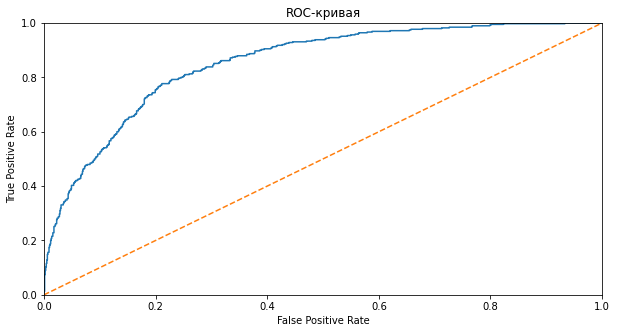

In [247]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

**Вывод**: в заключении проекта останавливаем выбор на RandomForestClassifier
- качество модели по метрике AUC-ROC достаточно высокое для решения задачи
- качество по дополнительной метрике accuracy приемлимое
- время, затрачиваемое на обучение соспоставимо с другими моделями

## Общий вывод

В данном проекте перед нами стояла задача бинарной классификации. Для исследования были предложены 4 датасета. Проделано:
- Исходные датасеты были предобработаны и объединены в один с учетом общего признака "customerID"
- Изучили корреляцию признаков при помощи библиотеки **Phik**
- Провели кодирование и масштабирование признаков перед обучением моделей
- Провели обучение моделей, кросс-валидацией подобрали оптимальные гиперпараметры
- Провели тестирование моделей, оптимальной моделью для решения поставленной задачи определили RandomForestClassifier